# Date Cleaning, Exploratory Data Analysis (EDA) and Feature Engineering 

In [10]:
import pathlib, pandas as pd, numpy as np, matplotlib.pyplot as plt

plt.style.use("ggplot")
pd.set_option('display.max_columns', None)  
DATA_DIR = pathlib.Path("../data/raw")  # adjust if needed

## 1. Load raw CSVs  
All daily EOHSummary files are concatenated into a single DataFrame.

### 1.1 Basic data cleaning
* merge **`binance_eoh_summary.csv`** and **`binance_spot.csv`** data
* Combine **`date`** & **`hour`** → UTC `timestamp`  
* Ensure numeric dtypes  
* Drop obvious duplicates / sort index
* Drop rows with **`best_ask_price`**, **`best_bid_price`**, **`volume_contracts`** ==0.0
* split **`strike`** in string type into **`expiry`** in datetime type and **`strike price`** in float type

In [11]:
# Load data
df_eoh = pd.read_csv("data/raw/binance_eoh_summary.csv")
df_spot = df = pd.read_csv("data/raw/binance_spot.csv")

# Rename close -> spot_close in df_spot
df_spot = df_spot.rename(columns={"close": "spot_close"})

# merge df_eoh and df_spot with same date and hour
df = df_eoh.merge(df_spot, on=["date","hour"],
                how="left", validate="many_to_one")

# combine date + hour (0-23) into one UTC timestamp and put it in df['date']
df['date'] = pd.to_datetime(df['date'], utc=True) + pd.to_timedelta(df["hour"], unit="h") 

# Drop duplicates
df.drop_duplicates()

# Drop when no market makers and no trades
mark_drop = (df['best_ask_price']==0.0) & (df['best_bid_price']==0.0) & (df['volume_contracts']==0.0)
df = df[~mark_drop]

# Split strike into expiry and strike price
df[["strike_date", "strike_price"]] = df["strike"].str.split("-", expand=True)
df["expiry_date"]  = pd.to_datetime(df["strike_date"], format="%y%m%d", utc=True)  # ie) 23‑05‑19 
df['expiry_date'] = pd.to_datetime(df["expiry_date"].dt.date.astype(str) + " 08:00:00", utc=True) # ie) 23‑05‑19 08:00:00
df["strike_price"] = df["strike_price"].astype(float)                    

# Display
display(f"Columns: {df.columns.tolist()}")
display(df.head())
display(df.describe())
display(df.info())

"Columns: ['date', 'hour', 'symbol', 'underlying', 'type', 'strike', 'open', 'high', 'low', 'close', 'volume_contracts', 'volume_usdt', 'best_bid_price', 'best_ask_price', 'best_bid_qty', 'best_ask_qty', 'best_buy_iv', 'best_sell_iv', 'mark_price', 'mark_iv', 'delta', 'gamma', 'vega', 'theta', 'openinterest_contracts', 'openinterest_usdt', 'spot_close', 'strike_date', 'strike_price', 'expiry_date']"

,date,hour,symbol,underlying,type,strike,open,high,low,close,volume_contracts,volume_usdt,best_bid_price,best_ask_price,best_bid_qty,best_ask_qty,best_buy_iv,best_sell_iv,mark_price,mark_iv,delta,gamma,vega,theta,openinterest_contracts,openinterest_usdt,spot_close,strike_date,strike_price,expiry_date
0,2023-05-18 00:00:00+00:00,0,BTC-230519-33000-C,BTCUSDT,C,230519-33000,10.0,10.0,5.0,5.0,3.38,3.38,0.0,30.0,0.00,0.06,NaN,1.634789,7.0,1.342394,0.010499,0.000013,0.452595,-23.518253,27.91,7.635908e+05,27357.42,230519,33000.0,2023-05-19 08:00:00+00:00
1,2023-05-18 00:00:00+00:00,0,BTC-230929-40000-P,BTCUSDT,P,230929-40000,12870.0,12870.0,12870.0,12870.0,0.00,0.00,12760.0,13910.0,1.50,1.50,NaN,0.673494,13203.0,0.516372,-0.854563,0.000027,37.899140,-7.286395,19.99,5.469072e+05,27357.42,230929,40000.0,2023-09-29 08:00:00+00:00
2,2023-05-18 01:00:00+00:00,1,BTC-230526-21000-C,BTCUSDT,C,230526-21000,6805.0,6805.0,6805.0,6805.0,0.00,0.00,6025.0,6660.0,1.50,5.81,NaN,1.517811,6358.0,0.908905,0.976973,0.000015,2.240647,-12.342624,39.99,1.092726e+06,27323.21,230526,21000.0,2023-05-26 08:00:00+00:00
3,2023-05-18 02:00:00+00:00,2,BTC-230526-12000-C,BTCUSDT,C,230526-12000,16000.0,16000.0,16000.0,16000.0,0.00,0.00,14655.0,16015.0,5.12,5.49,NaN,4.567490,15349.0,1.050000,1.000000,0.000000,0.000012,-0.000079,0.01,2.735262e+02,27349.32,230526,12000.0,2023-05-26 08:00:00+00:00
4,2023-05-18 03:00:00+00:00,3,BTC-230630-24000-P,BTCUSDT,P,230630-24000,655.0,655.0,640.0,640.0,16.52,16.52,515.0,540.0,20.11,20.00,NaN,0.490628,527.0,0.485774,-0.192610,0.000060,25.749171,-14.488348,8.18,2.238020e+05,27365.69,230630,24000.0,2023-06-30 08:00:00+00:00


,hour,open,high,low,close,volume_contracts,volume_usdt,best_bid_price,best_ask_price,best_bid_qty,best_ask_qty,best_buy_iv,best_sell_iv,mark_price,mark_iv,delta,gamma,vega,theta,openinterest_contracts,openinterest_usdt,spot_close,strike_price
count,791932.000000,791932.000000,791932.000000,791932.000000,791932.000000,791932.000000,791932.000000,791932.000000,7.919320e+05,791932.000000,791932.000000,0.0,7.919320e+05,791932.000000,791932.000000,791932.000000,791932.000000,791932.000000,791932.000000,789426.000000,7.894260e+05,791932.000000,791932.000000
mean,11.493545,2064.151051,2094.939913,2031.878223,2058.411252,5.266295,5.266295,3621.360445,5.365261e+03,4.724368,5.268372,NaN,1.012615e+00,4387.332918,0.545885,-0.027345,0.000091,26.129270,-20.532831,33.352297,9.301556e+05,28035.550461,31495.847497
std,6.922525,3828.841758,3827.610999,3829.827201,3829.184156,20.022539,20.022539,6745.676533,1.129904e+05,6.203285,5.472180,NaN,1.506867e+00,8035.553916,0.182413,0.611507,0.000243,28.371940,353.136608,54.160430,1.506550e+06,1744.051732,11937.453245
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,-1.000000e-08,0.100000,0.150000,-1.000000,0.000000,0.000000,-107511.607044,0.000000,0.000000e+00,24923.510000,12000.000000
25%,5.000000,25.000000,30.000000,15.000000,20.000000,0.000000,0.000000,165.000000,2.000000e+02,1.500000,2.440000,NaN,4.405503e-01,213.000000,0.413448,-0.552322,0.000017,4.356050,-20.171028,0.070000,1.850853e+03,26551.150000,25000.000000
50%,11.000000,470.000000,525.000000,415.000000,455.000000,0.000000,0.000000,1180.000000,1.400000e+03,2.780000,3.170000,NaN,5.561456e-01,1412.000000,0.501137,0.000000,0.000039,14.770528,-10.632292,10.090000,2.813576e+05,27425.710000,29000.000000
75%,17.000000,2570.000000,2625.000000,2500.000000,2560.000000,1.940000,1.940000,4250.000000,5.215000e+03,5.140000,5.480000,NaN,8.309594e-01,4993.000000,0.660954,0.455104,0.000093,39.211227,-6.234922,42.990000,1.215724e+06,29824.010000,34000.000000
max,23.000000,38300.000000,38300.000000,38300.000000,38300.000000,1165.060000,1165.060000,56335.000000,1.000000e+08,212.900000,200.000000,NaN,9.999999e+00,60285.000000,1.800000,1.000000,0.054917,127.575690,0.000000,471.990000,1.492825e+07,33315.920000,85000.000000


<class 'pandas.core.frame.DataFrame'>
Index: 791932 entries, 0 to 796971
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   date                    791932 non-null  datetime64[ns, UTC]
 1   hour                    791932 non-null  int64              
 2   symbol                  791932 non-null  object             
 3   underlying              791932 non-null  object             
 4   type                    791932 non-null  object             
 5   strike                  791932 non-null  object             
 6   open                    791932 non-null  float64            
 7   high                    791932 non-null  float64            
 8   low                     791932 non-null  float64            
 9   close                   791932 non-null  float64            
 10  volume_contracts        791932 non-null  float64            
 11  volume_usdt             791932 

None

## 2. Exploratory Data Analysis (EDA)
### 2.1  Check percentage of rows with nan

In [12]:
# check percentage of rows with nan
na_pct = df.isna().mean().sort_values(ascending=False).head()
print("Top NA ratios:\n", na_pct)

Top NA ratios:
 best_buy_iv               1.000000
openinterest_usdt         0.003164
openinterest_contracts    0.003164
date                      0.000000
hour                      0.000000
dtype: float64


### 2.2 Underlying distribution vs Strike coverage

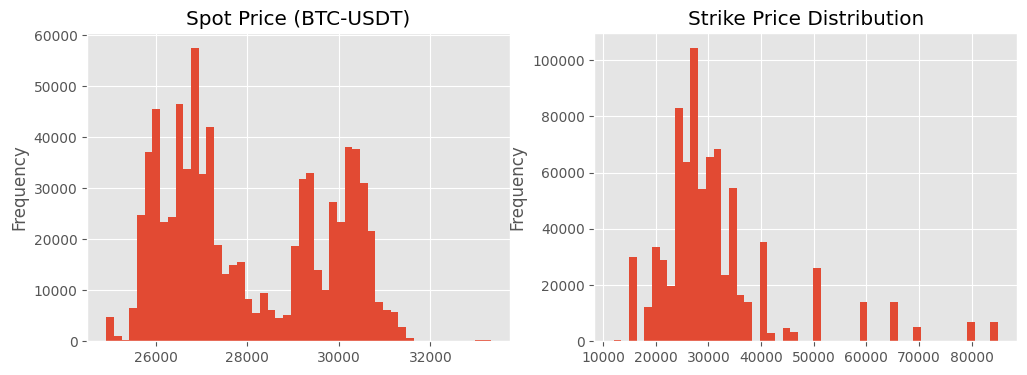

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
df["spot_close"].plot(kind="hist", bins=50, ax=ax[0], title="Spot Price (BTC-USDT)")
df["strike_price"].plot(kind="hist", bins=50, ax=ax[1], title="Strike Price Distribution")
plt.show()

### 2.3 Daily traded volume (contracts)

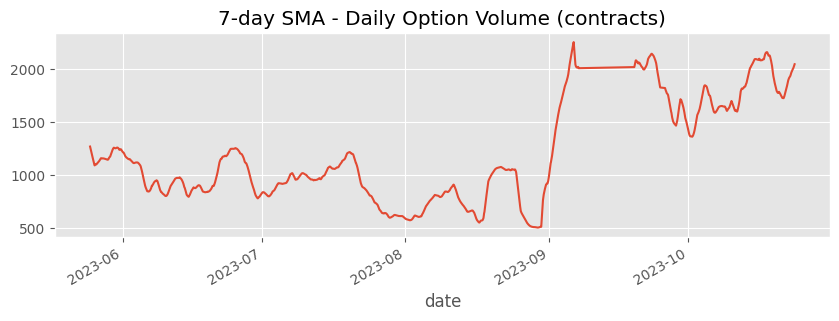

In [14]:
vol_day = (df.groupby(df['date'])["volume_contracts"]
              .sum()
              .rolling(7*24).mean())  # 7-day SMA
vol_day.plot(figsize=(10,3), title="7-day SMA - Daily Option Volume (contracts)")
plt.show()

### 2.4 Implied‐Vol snapshot sanity

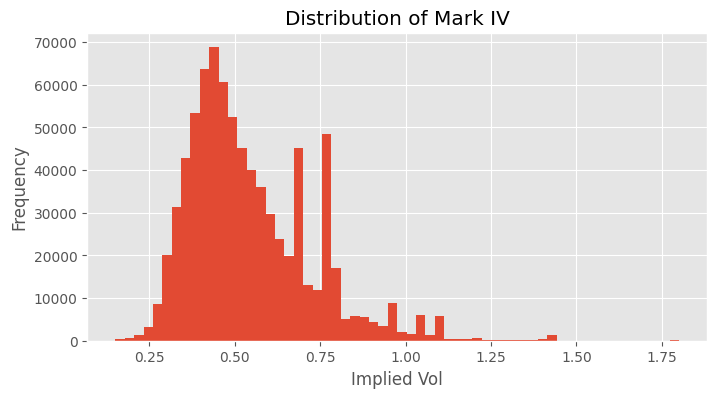

In [15]:
df["mark_iv"].plot(figsize=(8,4),kind="hist", bins=60, title="Distribution of Mark IV")
plt.xlabel("Implied Vol")
plt.show()

## 5. Feature Engineering

Create features relevant to the implied volatility surface
* **`moneyness`**: **`spot_close`** / **`strike_price`**  
* **`days_to_expiry`**: (**`expiry`** - **`date`**).dt.days  
* **`iv_zscore`**: intra-day relative IV (centre & scale per date)

Additional Data Cleaning
* Remove data with **`time_to_expiry == 0.0`**
* Drop na in **`mark_iv`** and **`log_moneyness`**
* Drop option data that are outside of bounds: **`days to expiry`**: [11,180]; **`log_moneyness`**: [-inf,0.15]

In [16]:
df["days_to_expiry"] = (df["expiry_date"] - df['date']).dt.days
df['time_to_expiry'] = (df["expiry_date"] - df["date"]).dt.total_seconds().clip(lower=0)/(365.25 * 24 * 3600)
df["log_moneyness"] = np.log(df["spot_close"] / df["strike_price"])

df = df[df['time_to_expiry']>0.]
df = df.dropna(subset=["mark_iv","log_moneyness"])

# Drop option data that are outside of bounds: days to expiry: [20,180]; log_moneyness: [-inf,0.15]
df = df[(df['days_to_expiry'] >= 16) & (df['days_to_expiry'] <= 180)]

# Drop option data that are deep in the money (ITM)
df = df[((df['log_moneyness'] < 0.15) & (df['type']=="C")) | ((df['log_moneyness'] > -0.15) & (df['type']=="P"))]

## 6. Verification of Implied Volatility in Binance Data

* usd BS model to calculate implied volatility for each option using **`scipy.optimize.brentq`** root solving method
* compared IV with binance **`mark_iv`** data 
* filter out data that is outside of 5% percentage error 

### Further improvements to be done
* try various methods instead of relying on Brent method only ie) Newton Rapson, Bisection

In [17]:
import math
from scipy.stats import norm
from scipy.optimize import brentq

def bs_price(S, K, T, r, q, sigma, opt_type):
    """Black-Scholes price for European call/put."""
    d1 = (math.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    if opt_type == "C":
        return S*math.exp(-q*T)*norm.cdf(d1) - K*math.exp(-r*T)*norm.cdf(d2)
    else:       # opt_type == "P"
        return K*math.exp(-r*T)*norm.cdf(-d2) - S*math.exp(-q*T)*norm.cdf(-d1)

def implied_vol(C_mkt, S, K, T, opt_type, r, q):
    f = lambda sig: bs_price(S, K, T, r, q, sig, opt_type) - C_mkt
    return brentq(f, 1e-4, 5.0)          # safe bracket [0.0001, 5]

In [18]:
def safe_iv(row):
    """
    Return implied vol for this row, or NaN if the solver fails.
    """
    try:
        return implied_vol(
            C_mkt   = row["mark_price"],
            S       = row["spot_close"],
            K       = row["strike_price"],
            T       = row["time_to_expiry"],
            opt_type= row["type"],
            r       = 0.,
            q       = 0.,
        )
    except ValueError:            # e.g. f(a) & f(b) same sign
        return np.nan
    
df["iv_calc"]   = df.apply(safe_iv, axis=1)
df["pct_error"] = 100 * (df["mark_iv"] - df["iv_calc"]) / df["mark_iv"]
df.loc[df["mark_iv"] == 0, "pct_error"] = np.nan
mask_bad = df["iv_calc"].isna()
df_good  = df.loc[~mask_bad].copy()   # rows to keep
df_bad   = df.loc[mask_bad].copy()    # rows to drop / review

In [19]:
thresh = 5 # in percentage (%)
mask_bad2 = (df["pct_error"].abs() > thresh)
df_good2 = df_good.loc[~mask_bad2]
print(f"percentage of data within +-{thresh}% error: {len(df_good2)/len(df_good)*100:.3} %")

percentage of data within +-5% error: 99.9 %


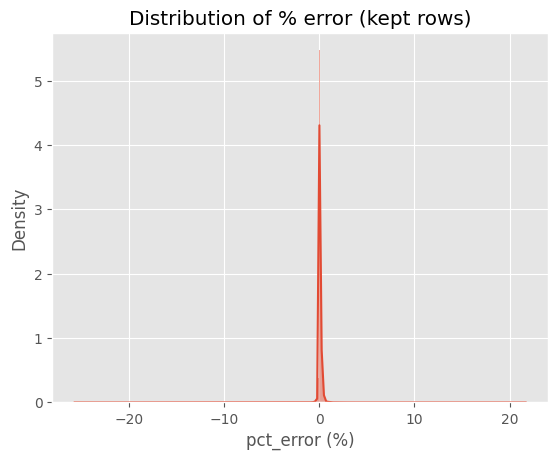

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(
    data=df_good["pct_error"],
    kde=True,
    stat="density",
    bins="auto",
    edgecolor="white",
)
plt.title("Distribution of % error (kept rows)")
plt.xlabel("pct_error (%)")
plt.show()

## 7. Save data

In [21]:
df_good.to_csv('data/modified/binance_option.csv',index=False)